# Analysis of MD data descriptions

## Prerequise packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Description length analysis

In [2]:
datasets = pd.read_parquet(
    "https://sandbox.zenodo.org/record/1169962/files/datasets.parquet"
)
# Create a description length column
df = datasets.copy()
df.loc[:, "description_length"] = df["description"].str.len() + df["title"].str.len()
if df["description_length"].isnull().values.any():
    df = df.dropna(subset = ["description_length", "title", "description"])
print("Number of description : ", df.shape[0])

Number of description :  1948


### Describe for each dataset

In [3]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
grouped = df.groupby(["dataset_origin"])["description_length"]
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
dataset_origin,,,,,,,,
figshare,913,826,799,14,110,583,1494,7100
osf,24,289,264,30,136,191,377,1171
zenodo,1011,809,797,30,383,604,980,11362


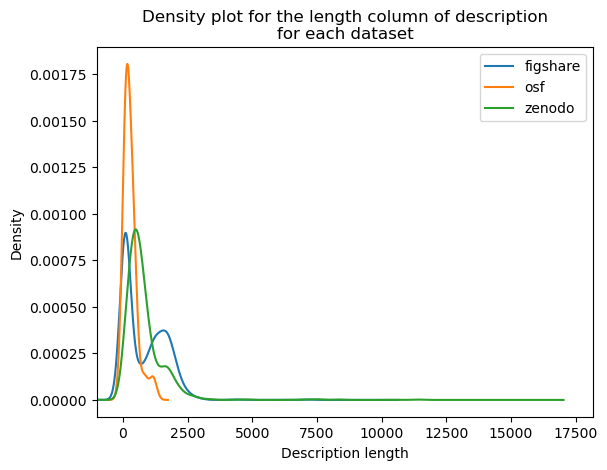

In [4]:
targets = grouped.groups.keys()
plt.title("Density plot for the length column of description\nfor each dataset")
for key in targets:
    x = grouped.get_group(key)
    x.plot.kde(label = key)
plt.xlim(-1000,)
plt.xlabel("Description length")
plt.legend(loc="upper right")
plt.show()

### Describe for all datasets

In [5]:
pd.DataFrame(df["description_length"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
description_length,1948,810,795,14,182,594,1244,11362


Selected threshold :  600
Number of description above the threshold :  964


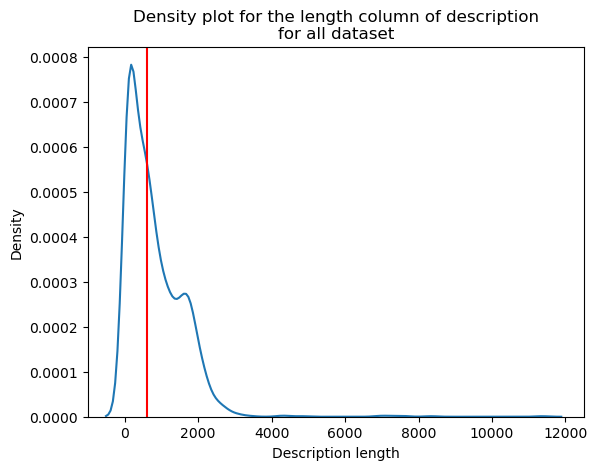

In [6]:
threshold = 600
sns.kdeplot(data=df, x="description_length")
plt.title("Density plot for the length column of description\nfor all dataset")
plt.axvline(x = threshold, color = "red", label = 'axvline - full height')
plt.xlim(-1000,)
plt.xlabel("Description length")
print("Selected threshold : ", threshold)
print("Number of description above the threshold : ", len(df[df["description_length"] > threshold]))
plt.show()

The threshold was chosen empirically as shown with the red line. It should ensure that the number of descriptions is large to make sure a large training data. Here, we have 950 descriptions with a threshold = 600.

## Lipid and protein composition

The objective of this part is to analyse the homogeneity of protein and lipid data to make sure a good diversity of training data.

Without              2941
Only lipid           2825
Only protein         2162
Protein and lipid    1852
Name: composition, dtype: int64

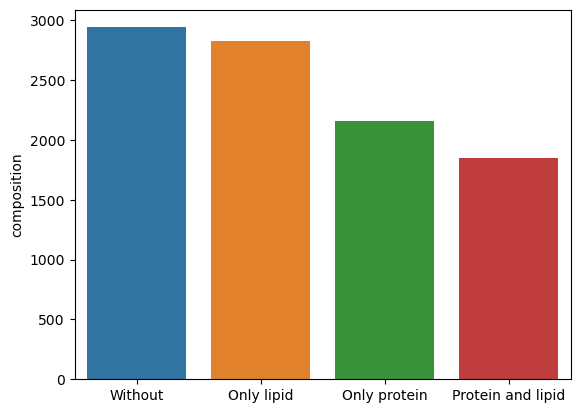

In [9]:
gro = pd.read_parquet(
    "https://sandbox.zenodo.org/record/1169962/files/gromacs_gro_files.parquet"
)
gro["composition"] = list(zip(
        gro["has_protein"],
        gro["has_lipid"],
))
combine_count = gro["composition"].value_counts()
combine_count.index = ["Without", "Only lipid", "Only protein", "Protein and lipid"]
barplot = sns.barplot(x=combine_count.index, y=combine_count)
combine_count

Here, we have 2080 .gro files which are composed of lipids only and 1920 of proteins only. We will choose 50% proteins and 50% lipids where the description is **unique**.

Only lipid           364
Only protein         172
Without              135
Protein and lipid     92
Name: composition, dtype: int64

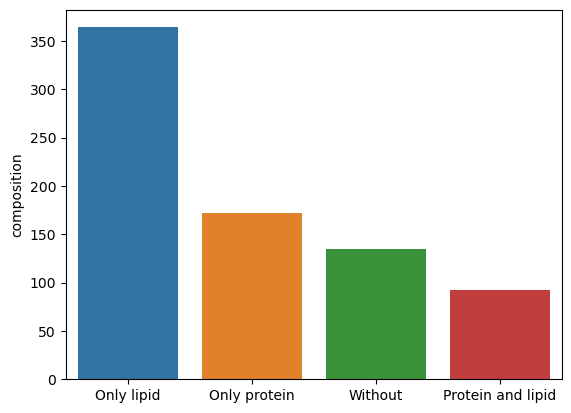

In [10]:
# Merge to obtain the description with the associated gro file.
gro_data = pd.merge(
    gro,
    datasets,
    how="left",
    on=["dataset_id", "dataset_origin"],
    validate="many_to_one",
)

# Remove the duplicate description
gro_data = gro_data.drop_duplicates("description")

# Get the lipid and protein compositions
gro_data["composition"] = list(zip(
        gro_data["has_protein"],
        gro_data["has_lipid"],
))
combine_count = gro_data["composition"].value_counts()
combine_count.index = ["Only lipid", "Only protein", "Without", "Protein and lipid"]
barplot = sns.barplot(x=combine_count.index, y=combine_count)
combine_count

Considering the selected threshold, the suppression of duplicates has resulted a higher proportion of .gro files containing only lipids. So we will select 50% fo the lipids by calling the sample function of pandas.

## Cosinus similarity

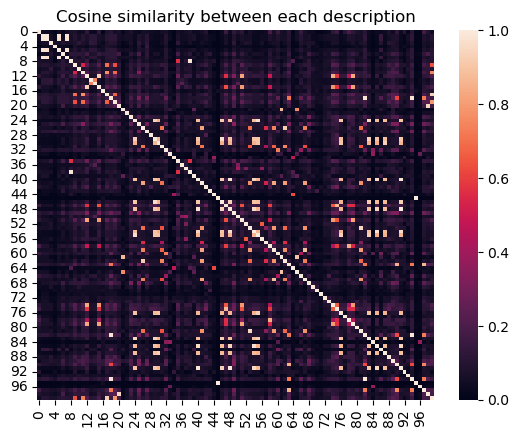

In [11]:
cols = ["title", "description"]
df["corpus"] = df[cols].apply(lambda row: " ".join(row.values.astype(str)), axis=1)
vectorizer = TfidfVectorizer()
trsfm = vectorizer.fit_transform(df["corpus"])
data = pd.DataFrame([cosine_similarity(trsfm[i:i+1], trsfm)[0] for i in range(len(df["corpus"]))])
heatmap = sns.heatmap(data.iloc[0:100, 0:100]).set(title="Cosine similarity between each description")

The cosine similarity will allow us to select descriptions that are not very similar to make sure a good diversity of data. If a score is low then it's not similar.